In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation


from imblearn.over_sampling import ADASYN


import seaborn as sns
import xgboost
import re
import nltk
import pymorphy2
import enchant

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

/Users/Roman/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("credit_train.csv", sep = ";", encoding='cp1251')
test = pd.read_csv("credit_test.csv", sep = ";", encoding='cp1251')

In [3]:
y = train['open_account_flg']

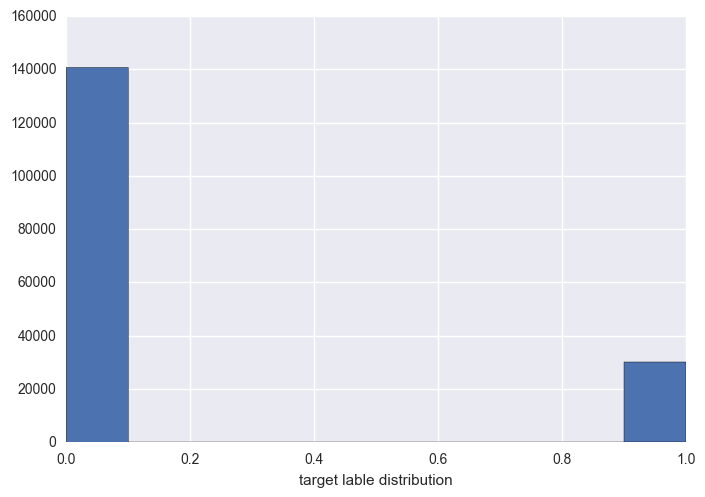

In [4]:
### посмотрим распределение целевой метки в train. Видим, что отношение между классами несбалансированное
y.hist()
plt.xlabel("target lable distribution")

In [5]:
train.gender = train.gender.map({"M":1, "F":0})
test.gender = test.gender.map({"M":1, "F":0})

In [6]:
train.rename(columns={"open_account_flg":"target"}, inplace=True)

In [7]:
train_col = train.columns.drop("target")

In [8]:
train['score_shk'] = train['score_shk'].apply(lambda x: x.replace(",","."))
test['score_shk'] = test['score_shk'].apply(lambda x: x.replace(",","."))

train['score_shk'] = train['score_shk'].astype(float)
test['score_shk'] = test['score_shk'].astype(float)

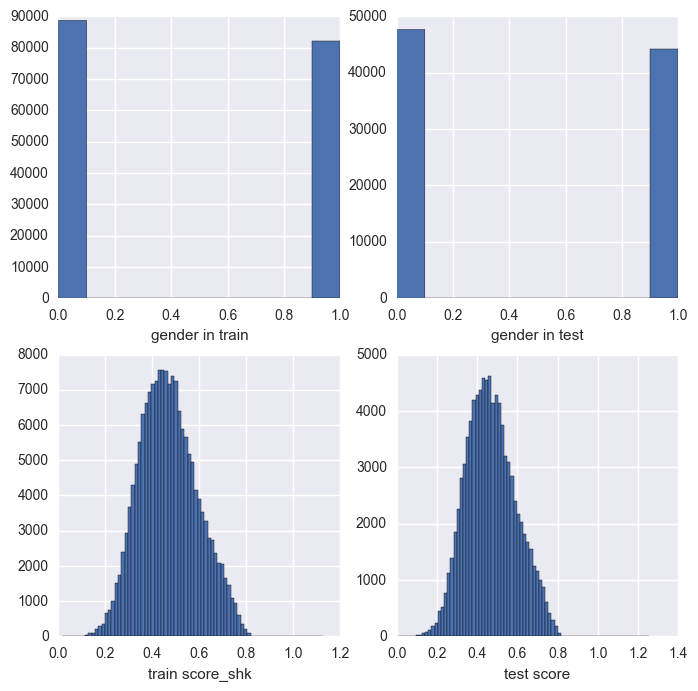

In [9]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.hist(train.gender)
plt.xlabel("gender in train")

plt.subplot(2,2,2)
plt.hist(test.gender)
plt.xlabel("gender in test")

plt.subplot(2,2,3)
plt.hist(train.score_shk, bins=80)
plt.xlabel("train score_shk")

plt.subplot(2,2,4)
plt.hist(test.score_shk, bins=80)
plt.xlabel("test score")

(array([  4.00000000e+00,   5.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   1.00000000e+01,   1.10000000e+01,
          1.10000000e+01,   2.40000000e+01,   2.00000000e+01,
          2.50000000e+01,   6.30000000e+01,   4.30000000e+01,
          7.50000000e+01,   1.06000000e+02,   1.14000000e+02,
          1.97000000e+02,   1.94000000e+02,   2.60000000e+02,
          4.61000000e+02,   4.20000000e+02,   5.26000000e+02,
          6.87000000e+02,   9.24000000e+02,   1.10900000e+03,
          1.25900000e+03,   1.69400000e+03,   1.94800000e+03,
          2.32600000e+03,   2.87100000e+03,   3.22700000e+03,
          3.84500000e+03,   4.17500000e+03,   4.72600000e+03,
          5.40300000e+03,   5.56600000e+03,   6.03800000e+03,
          6.39100000e+03,   6.44100000e+03,   6.71300000e+03,
          7.23800000e+03,   7.09700000e+03,   7.03000000e+03,
          7.14800000e+03,   7.17200000e+03,   7.20100000e+03,
          6.16200000e+03,   6.05600000e+03,   5.72300000e+03,
        

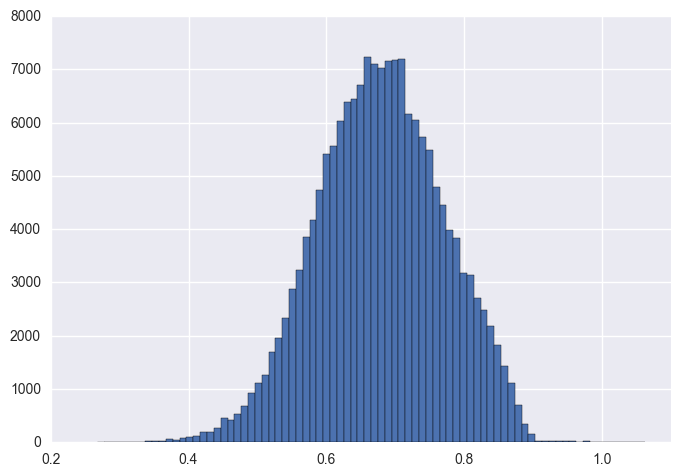

In [55]:
plt.hist(np.sqrt(train[train.score_shk > 0].score_shk), bins=80)

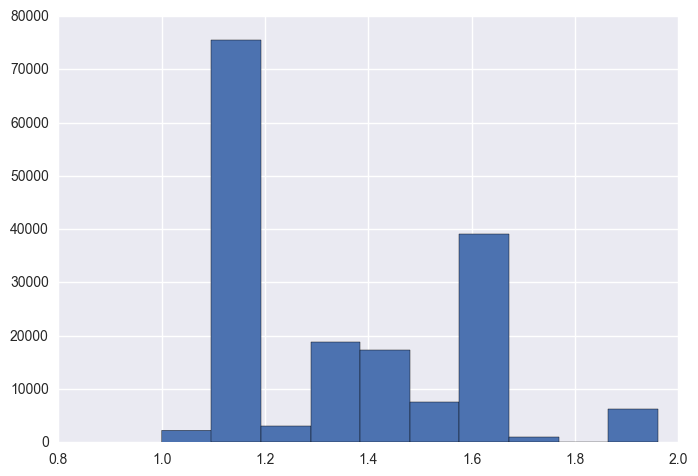

In [57]:
train.tariff_id.hist()

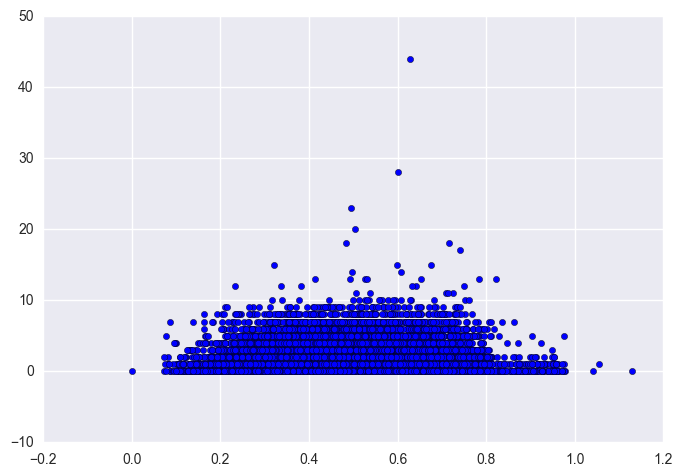

In [72]:
plt.scatter(train.score_shk.unique(), train.groupby("score_shk").target.sum())

In [11]:
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

In [12]:
train['monthly_income'] = train['monthly_income'].astype(float)
test['monthly_income'] = test['monthly_income'].astype(float)

train["city_mean_income"] = code_mean(train, 'living_region', 'monthly_income')
train.drop("living_region", axis=1, inplace=True)

test["city_mean_income"] = code_mean(test, 'living_region', 'monthly_income')
test.drop("living_region", axis=1, inplace=True)

In [13]:
train['credit_sum'] = train['credit_sum'].apply(lambda x: x.replace(",","."))
test['credit_sum'] = test['credit_sum'].apply(lambda x: x.replace(",","."))

train['credit_sum'] = train['credit_sum'].astype(float)
test['credit_sum'] = test['credit_sum'].astype(float)

In [14]:
train["credit_pay"] = train["credit_sum"] / train["credit_month"]
train["money_for_life"] = train["monthly_income"] - train["credit_pay"]
train["dif_city"] = train["monthly_income"] - train["city_mean_income"]

test["credit_pay"] = test["credit_sum"] / test["credit_month"]
test["money_for_life"] = test["monthly_income"] - test["credit_pay"]
test["dif_city"] = test["monthly_income"] - test["city_mean_income"]

In [15]:
train.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,monthly_income,credit_count,overdue_credit_count,target,city_mean_income,credit_pay,money_for_life,dif_city
0,1,1,48,MAR,UMN,59998.00,10,1.6,0.770249,GRD,30000.0,1.0,1.0,0,36905.696393,5999.800000,24000.200000,-6905.696393
1,2,0,28,MAR,UMN,10889.00,6,1.1,0.248514,GRD,43000.0,2.0,0.0,0,62130.784048,1814.833333,41185.166667,-19130.784048
2,3,1,32,MAR,SPC,10728.00,12,1.1,0.459589,SCH,23000.0,5.0,0.0,0,35838.636364,894.000000,22106.000000,-12838.636364
3,4,0,27,DIV,SPC,12009.09,12,1.1,0.362536,GRD,17000.0,2.0,0.0,0,31301.444396,1000.757500,15999.242500,-14301.444396
4,5,1,45,MAR,SPC,16908.89,10,1.1,0.421385,SCH,25000.0,1.0,0.0,0,31411.834395,1690.889000,23309.111000,-6411.834395


In [22]:
cont_col = train.columns.drop(["marital_status", "job_position","education"])

In [23]:
train[cont_col].head()

,client_id,gender,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,target,city_mean_income,credit_pay,money_for_life,dif_city
0,1,1,48,59998.00,10,1.6,0.770249,30000.0,1.0,1.0,0,36905.696393,5999.800000,24000.200000,-6905.696393
1,2,0,28,10889.00,6,1.1,0.248514,43000.0,2.0,0.0,0,62130.784048,1814.833333,41185.166667,-19130.784048
2,3,1,32,10728.00,12,1.1,0.459589,23000.0,5.0,0.0,0,35838.636364,894.000000,22106.000000,-12838.636364
3,4,0,27,12009.09,12,1.1,0.362536,17000.0,2.0,0.0,0,31301.444396,1000.757500,15999.242500,-14301.444396
4,5,1,45,16908.89,10,1.1,0.421385,25000.0,1.0,0.0,0,31411.834395,1690.889000,23309.111000,-6411.834395
